### *BAD GENIUS: ANIMAL CLASSIFICATION*

### Group members:

 1. Muhammad Muhairis bin Azman (2114599)
 2. Muhammad Hafidzuddin Hanif Danial Bin Norizal (2123651)
 3. Shareen Arawie Bin Hisham (2116943)
 4. Ibrahim Bin Nasrum (2116467)


## 1. Load the data and visulization of data


In [1]:
import os
import numpy as np
import pandas as pd
import timm
import torchvision.transforms as T
from wildlife_datasets.datasets import AnimalCLEF2025
from wildlife_tools.features import DeepFeatures
from wildlife_tools.similarity import CosineSimilarity
def create_sample_submission(dataset_query, predictions, file_name='sample_submission.csv'):
    df = pd.DataFrame({
        'image_id': dataset_query.metadata['image_id'],
        'identity': predictions
    })
    df.to_csv(file_name, index=False)

In [2]:
root = r"C:\Users\ACER\Desktop\Education\MCTA 4363\2-CLEF_Animal_Classification\Data\animal-clef-2025"
transform_display = T.Compose([
    T.Resize([384, 384]),
    ])
transform = T.Compose([
    *transform_display.transforms,
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

In [3]:
dataset = AnimalCLEF2025(root, transform=transform_display, load_label=True)

,image_id,identity,path,date,orientation,species,split,dataset
0,0,LynxID2025_lynx_37,images/LynxID2025/database/000f9ee1aad063a4485...,NaN,right,lynx,database,LynxID2025
1,1,LynxID2025_lynx_37,images/LynxID2025/database/0020edb6689e9f78462...,NaN,left,lynx,database,LynxID2025
2,2,LynxID2025_lynx_49,images/LynxID2025/database/003152e4145b5b69400...,NaN,left,lynx,database,LynxID2025
3,3,NaN,images/LynxID2025/query/003b89301c7b9f6d18f722...,NaN,back,lynx,query,LynxID2025
4,4,LynxID2025_lynx_13,images/LynxID2025/database/003c3f82011e9c3f849...,NaN,right,lynx,database,LynxID2025
...,...,...,...,...,...,...,...,...
15204,15204,NaN,images/SeaTurtleID2022/query/images/fecd2dfed0...,2024-06-07,NaN,loggerhead turtle,query,SeaTurtleID2022
15205,15205,NaN,images/SeaTurtleID2022/query/images/ff1a0c812b...,2023-06-28,NaN,loggerhead turtle,query,SeaTurtleID2022
15206,15206,NaN,images/SeaTurtleID2022/query/images/ff22f1cfa6...,2024-06-09,NaN,loggerhead turtle,query,SeaTurtleID2022
15207,15207,NaN,images/SeaTurtleID2022/query/images/ff5d5116d1...,2023-06-21,NaN,loggerhead turtle,query,SeaTurtleID2022


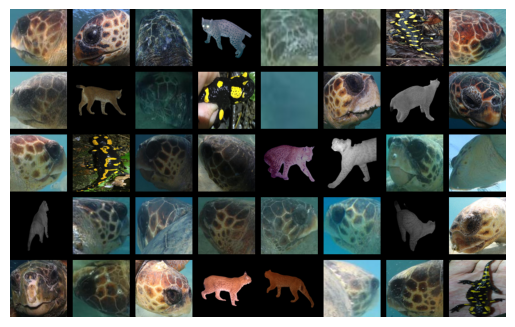

In [4]:
dataset.plot_grid()
dataset.metadata

In [5]:
dataset.metadata[['dataset', 'split']].value_counts()

dataset           split   
SeaTurtleID2022   database    8729
LynxID2025        database    2957
SalamanderID2025  database    1388
LynxID2025        query        946
SalamanderID2025  query        689
SeaTurtleID2022   query        500
Name: count, dtype: int64

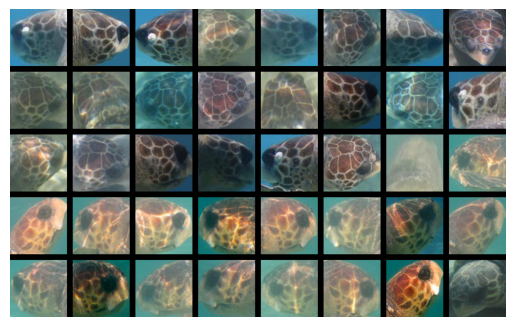

In [6]:
idx = dataset.metadata['identity'].str.startswith('SeaTurtleID2022')
idx[idx.isnull()] = False
dataset.plot_grid(idx=idx);

## 2. Inference with MegaDescriptor model

In [7]:
# Loading the dataset
dataset = AnimalCLEF2025(root, transform=transform, load_label=True)
dataset_database = dataset.get_subset(dataset.metadata['split'] == 'database')
dataset_query = dataset.get_subset(dataset.metadata['split'] == 'query')
n_query = len(dataset_query)

In [8]:
#Loading the model
name = 'hf-hub:BVRA/MegaDescriptor-L-384'
device = 'cuda'
model = timm.create_model(name, num_classes=0, pretrained=True)
extractor = DeepFeatures(model, device=device, batch_size=32, num_workers=0)
features_database = extractor(dataset_database)
features_query = extractor(dataset_query)

100%|███████████████████████████████████████████████████████████████| 67/67 [07:01<00:00,  6.29s/it]


In [20]:
similarity = CosineSimilarity()(features_query, features_database)

In [21]:
pred_idx = similarity.argsort(axis=1)[:,-1]
pred_scores = similarity[range(n_query), pred_idx]

In [25]:
new_individual = 'new_individual'
threshold = 0.6
labels = dataset_database.labels_string
predictions = labels[pred_idx]
predictions[pred_scores < threshold] = new_individual
create_sample_submission(dataset_query, predictions, file_name='sample_submission_v2.csv')

## 3. Performance metric

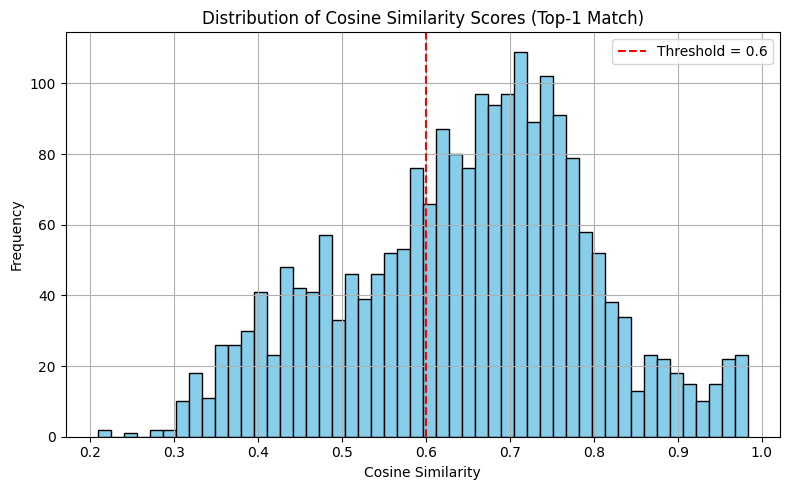

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import torch  # only if using torch tensors

# Example pred_scores: replace this with your actual data
# pred_scores = [0.85, 0.92, 0.75, 0.6, 0.99, ...]
# Or if pred_scores is a tensor:
# pred_scores = torch.tensor([...])

# Convert to numpy if needed
if isinstance(pred_scores, torch.Tensor):
    pred_scores_np = pred_scores.cpu().numpy()
else:
    pred_scores_np = np.array(pred_scores)


plt.figure(figsize=(8, 5))
plt.hist(pred_scores_np, bins=50, color='skyblue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.title("Distribution of Cosine Similarity Scores (Top-1 Match)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
